<a href="https://colab.research.google.com/github/brwillia/nuc-3d/blob/main/nucleus_3d_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started With 3D Data in Scale Nucleus

---



In this tutorial, we'll walk through a demo of how to upload 3D Scenes to Nucleus using the open source PandaSet dataset.



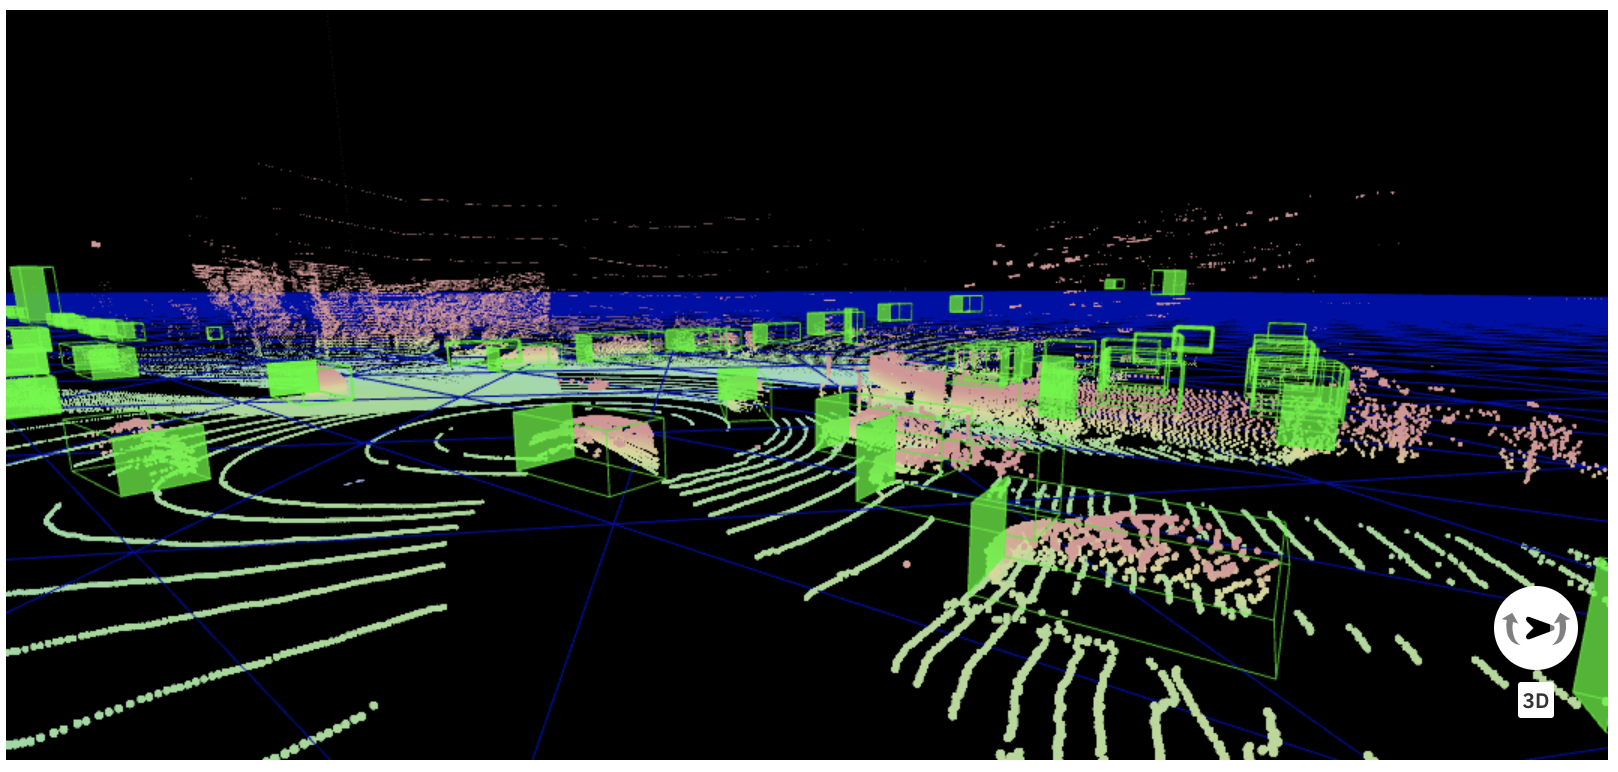

### Step 1: Install dependencies

In [ ]:
# Run this cell 2x! Please.
%%bash
pip install -U scale-nucleus urllib3 boto3 botocore

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.8
    Uninstalling urllib3-1.25.8:
      Successfully uninstalled urllib3-1.25.8


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandaset 0.2.dev0 requires urllib3==1.25.8, but you have urllib3 1.25.11 which is incompatible.
kapre 0.3.5 requires numpy>=1.18.5, but you have numpy 1.18.2 which is incompatible.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 5.2.0 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.13.0 which is incompatible.
google-colab 1.0.0 requires notebook~=5.3.0; python_version >= "3.0", but you have notebook 6.0.3 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.0.3 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.14.0 which is incompatible.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.0.4 which is incompatible.
datasci

In [ ]:
# Install pandaset devkit from GitHub
%%shell 
git clone https://github.com/scaleapi/pandaset-devkit.git
cd pandaset-devkit/python
pip install .

fatal: destination path 'pandaset-devkit' already exists and is not an empty directory.
Processing /content/pandaset-devkit/python
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Using cached urllib3-1.25.8-py2.py3-none-any.whl (125 kB)
  Created wheel for pandaset: filename=pandaset-0.2.dev0-py3-none-any.whl size=13428 sha256=603b6b03ea29754d67e5fc43f813ebd397a56d9f92217ab4a48d97eca9edee7c
  Stored in directory: /tmp/pip-ephem-wheel-cache-5w2_w6xk/wheels/2c/ae/0e/0fef1c7c1f45c462b26a048a8b556d65fde04b33b371c5e72a
Successfully built pandaset
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urll

In [ ]:
import os
import re
import json
from typing import List
from pandaset import DataSet
import boto3
from botocore import UNSIGNED
from botocore.client import Config

In [ ]:
import nucleus
from nucleus import NucleusClient, DatasetItem, Frame, LidarScene, CuboidAnnotation, Point3D

### Step 2 (Optional): Preprocessing Pandaset Pointclouds

The Nucleus Scene API only supports remote upload, such that users must specify urls that point to a JSON payload representing a pointcloud.  The JSON payload is expected to have the following format:

```
{
  "points": {
    { x: 100.27, y: 1005.75, z: 3.40 }, 
    { x: 102.51, y: 761.75, z: 3.17 }, 
    ...
  },
  "device_position": (0,0,0)
  "device_heading": {
    "x": 1,
    "y": 1,
    "z": 1,
    "w": 1
  }
}
```

The points field represents the raw data of the pointcloud, which device_position and device_heading represent the coordinates and rotation of the sensor itself.

In this section of the tutorial, we'll show how to process raw data from the public pandaset lidar dataset into the expected frame format.

#### Raw Pandaset Format

When initially downloaded, the pandaset dataset, has the following file format:

```
.
├── LICENSE.txt
├── annotations
│   ├── cuboids
│   │   ├── 00.pkl.gz
│   │   .
│   │   .
│   │   .
│   │   └── 79.pkl.gz
│   └── semseg  // Semantic Segmentation is available for specific scenes
│       ├── 00.pkl.gz
│       .
│       .
│       .
│       ├── 79.pkl.gz
│       └── classes.json
├── camera
│   ├── back_camera
│   │   ├── 00.jpg
│   │   .
│   │   .
│   │   .
│   │   ├── 79.jpg
│   │   ├── intrinsics.json
│   │   ├── poses.json
│   │   └── timestamps.json
│   ├── front_camera
│   │   └── ...
│   ├── front_left_camera
│   │   └── ...
│   ├── front_right_camera
│   │   └── ...
│   ├── left_camera
│   │   └── ...
│   └── right_camera
│       └── ...
├── lidar
│   ├── 00.pkl.gz
│   .
│   .
│   .
│   ├── 79.pkl.gz
│   ├── poses.json
│   └── timestamps.json
└── meta
    ├── gps.json
    └── timestamps.json

```

This format differs slightly from that which is expected by the Nucleus API. In particular, the pointcloud files are stored in compressed format and contain only (x,y,z) points, whereas device position and heading are stored separately in the `poses.json` file.

We'll be using the Pandaset DevKit, which contains utility functions for working with the Pandaset data format, to construct the target JSON payloads specified by the Nucleus payload format. More detailed documentation can be found at the [Scale Pandaset DevKit](https://github.com/scaleapi/pandaset-devkit)

In [ ]:
RAW_PANDASET_DIRECTORY = "pandaset_raw"
OUTPUT_DIR = "pandaset_processed"

In [ ]:
%%shell
wget https://pandaset-subset-raw.s3.us-west-2.amazonaws.com/pandaset_raw.zip
unzip pandaset_raw.zip
ls pandaset_raw

--2021-10-19 04:39:59--  https://pandaset-subset-raw.s3.us-west-2.amazonaws.com/pandaset_raw.zip
Resolving pandaset-subset-raw.s3.us-west-2.amazonaws.com (pandaset-subset-raw.s3.us-west-2.amazonaws.com)... 52.92.128.242
Connecting to pandaset-subset-raw.s3.us-west-2.amazonaws.com (pandaset-subset-raw.s3.us-west-2.amazonaws.com)|52.92.128.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1323438124 (1.2G) [application/zip]
Saving to: ‘pandaset_raw.zip’

pandaset_raw.zip    100%[===================>]   1.23G  21.7MB/s    in 61s     

2021-10-19 04:41:01 (20.8 MB/s) - ‘pandaset_raw.zip’ saved [1323438124/1323438124]

Archive:  pandaset_raw.zip
   creating: pandaset_raw/
   creating: pandaset_raw/023/
  inflating: __MACOSX/pandaset_raw/._023  
   creating: pandaset_raw/001/
  inflating: __MACOSX/pandaset_raw/._001  
   creating: pandaset_raw/006/
  inflating: __MACOSX/pandaset_raw/._006  
   creating: pandaset_raw/023/camera/
  inflating: __MACOSX/pandaset_raw/0

In [ ]:
dataset = DataSet("pandaset_raw")
# Each sequence corresponds to a scene identifier
sequences = dataset.sequences()
for seq in sequences[:2]:
    print("processing sequence: ", seq)
    curr_sequence = dataset[seq].load() # De-compress pointcloud
    base_path = f'{OUTPUT_DIR}/{seq}'
    curr_output_directory = f'{base_path}/lidar'
    os.makedirs(f"{curr_output_directory}/{base_path}", exist_ok=True)
    for i, (pos, frame) in enumerate(zip(curr_sequence.lidar.poses, curr_sequence.lidar)):
        # Get points in JSON format
        points_json = json.loads(frame.to_json(orient="records"))
        position = curr_sequence.lidar.poses
        pointcloud_obj = {
            "points": points_json,
            "device_heading": pos["heading"],
            "device_position": pos["position"],
        }
        index_str = f'0{i}' if i < 10 else str(i)
        outfile_path = f'{curr_output_directory}/{index_str}.json'
        print("writing file: ", outfile_path)
        with open(outfile_path, "w") as outfile:
            json.dump(pointcloud_obj, outfile)

processing sequence:  006
writing file:  pandaset_processed/006/lidar/00.json
writing file:  pandaset_processed/006/lidar/01.json
writing file:  pandaset_processed/006/lidar/02.json
writing file:  pandaset_processed/006/lidar/03.json
writing file:  pandaset_processed/006/lidar/04.json
writing file:  pandaset_processed/006/lidar/05.json
writing file:  pandaset_processed/006/lidar/06.json
writing file:  pandaset_processed/006/lidar/07.json
writing file:  pandaset_processed/006/lidar/08.json
writing file:  pandaset_processed/006/lidar/09.json
writing file:  pandaset_processed/006/lidar/10.json
writing file:  pandaset_processed/006/lidar/11.json
writing file:  pandaset_processed/006/lidar/12.json
writing file:  pandaset_processed/006/lidar/13.json
writing file:  pandaset_processed/006/lidar/14.json
writing file:  pandaset_processed/006/lidar/15.json
writing file:  pandaset_processed/006/lidar/16.json
writing file:  pandaset_processed/006/lidar/17.json
writing file:  pandaset_processed/006/

### Upload to your favorite cloud provider
Since Nucleus only handles upload frames via URL, the final step is to upload the processed data to your favorite cloud storage provider.  We've left this up to the user to set up.  But don't sweat - you'll be able to run the remaining cells if you skip this step. 

In [ ]:
%%shell
# aws s3 sync s3://pandaset_processed ./pandaset_processed

### Step 3: Read PandaSet files from S3

More information about PandaSet can be found at: https://scale.com/open-datasets/pandaset

For the purposes of this demo, we've pre-processed the PandaSet dataset into a more convenient format and made it accessible via a public S3 bucket. PandaSet is licensed under the following terms of use: https://scale.com/legal/pandaset-terms-of-use

In [ ]:
PUBLIC_PANDASET_BUCKET = "pandaset-public"

# Read S3 objects from public PandaSet bucket
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
paginator = s3.get_paginator('list_objects_v2')
result = paginator.paginate(Bucket=PUBLIC_PANDASET_BUCKET)

In [ ]:
# Get paths for all S3 objects
object_paths = []
for page in result:
    if "Contents" in page:
        for key in page["Contents"]:
            object_path = key["Key"]
            object_paths.append(object_path)

#### Data Exploration

Here's how our dataset is structured in S3. At the outermost level, we have scenes with numerical identifiers (`001`, `002`, etc). Within each scene, we have the directories `camera`, `lidar`, and `annotations`. Within camera, we have directories for different sensors (i.e. `front_camera`, `back_camera`, etc). At the innermost level, we have files containing images (jpg), pointclouds (json), or cuboid annotations (json) corresponding to a given frame. The filenames represent the temporal frame index.
    
```
001/
  lidar/
    00.json
    01.json
        ...
    79.json
  camera/
    back_camera/
        00.jpg
        01.jpg
        ...
        79.jpg
    front_camera/
        00.jpg
        01.jpg
        ...
        79.jpg
    ...
  annotations/
    cuboids/
        00.json
        01.json
            ...
        79.json
002/
  ...
```

In [ ]:
# Define some helper functions

def is_image_path(object_path: str):
    '''
    Returns True if object path points to an image file.
    
    Parameters
    ----------
    object_path: The url of an object in S3

    Returns
    -------
    bool: Whether the object path points to a camera image with format jpg 
    '''
    return "camera/" in object_path and ".jpg" in object_path

def is_pointcloud_path(object_path: str):
    '''
    Returns True if object path points to a pointcloud file.

    Parameters
    ----------
    object_path: The url of an object in S3

    Returns
    -------
    bool: Whether the object path points to a pointcloud file with format json 
    '''
    return "lidar/" in object_path and ".json" in object_path
  
def is_cuboid_path(object_path: str):
    '''
    Returns True if object path points to a file containing annotations.
    
    Parameters
    ----------
    object_path: The url of an object in S3

    Returns
    -------
    bool: Whether the object path points to a cuboid annotation file with format json 
    '''
    return "cuboids/" in object_path and ".json" in object_path

def read_json(path: str):
    '''
      Given an S3 path, tries to parse the file as a JSON file.
    '''
    s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
    content_object = s3.Object(BUCKET, path)
    file_content = content_object.get()['Body'].read().decode('utf-8')
    return json.loads(file_content)

In [ ]:
image_paths = []
pointcloud_paths = []
cuboid_paths = []

# Get paths for all images, pointclouds, and annotations in S3
for path in object_paths:
    if is_image_path(path):
        image_paths.append(path)
    elif is_pointcloud_path(path):
        pointcloud_paths.append(path)
    elif is_cuboid_path(path):
        cuboid_paths.append(path)

In [ ]:
print(image_paths)
print(pointcloud_paths)
print(cuboid_paths)

['pandaset_0/001/camera/back_camera/00.jpg', 'pandaset_0/001/camera/back_camera/01.jpg', 'pandaset_0/001/camera/back_camera/02.jpg', 'pandaset_0/001/camera/back_camera/03.jpg', 'pandaset_0/001/camera/back_camera/04.jpg', 'pandaset_0/001/camera/back_camera/05.jpg', 'pandaset_0/001/camera/back_camera/06.jpg', 'pandaset_0/001/camera/back_camera/07.jpg', 'pandaset_0/001/camera/back_camera/08.jpg', 'pandaset_0/001/camera/back_camera/09.jpg', 'pandaset_0/001/camera/back_camera/10.jpg', 'pandaset_0/001/camera/back_camera/11.jpg', 'pandaset_0/001/camera/back_camera/12.jpg', 'pandaset_0/001/camera/back_camera/13.jpg', 'pandaset_0/001/camera/back_camera/14.jpg', 'pandaset_0/001/camera/back_camera/15.jpg', 'pandaset_0/001/camera/back_camera/16.jpg', 'pandaset_0/001/camera/back_camera/17.jpg', 'pandaset_0/001/camera/back_camera/18.jpg', 'pandaset_0/001/camera/back_camera/19.jpg', 'pandaset_0/001/camera/back_camera/20.jpg', 'pandaset_0/001/camera/back_camera/21.jpg', 'pandaset_0/001/camera/back_cam

### Step 4: Construct LidarScenes

Scenes are the building blocks of 3D data in Nucleus, where a Scene represents a sequence of LiDAR point clouds and contextual camera images over time. This abstraction is implemented by the Nucleus LidarScene class. A LidarScene is a sequence of Frames over time, where each Frame contains exactly one point cloud and an optional set of camera images. 

There are multiple ways to construct a LidarScene. The first way is by [DatasetItem](https://dashboard.scale.com/nucleus/v1/docs/api?language=python#dataset-items). Since our S3 bucket is organized so that point clouds and images are divided by sensor (`camera/`, `lidar/`), we construct our scenes by item. This means we first create our scene and then add items to it by calling `scene.add_item` with the frame index, sensor name, and DatasetItem. Under the hood, LidarScene will then unify these sensors into frames. For example, `scene.add_item(0, "camera", image0)` adds the `image0` item to `frame 0` under the `camera` sensor.

The second way is by Frame. A Frame is a dictionary mapping sensor names to DatasetItems (i.e. `{"camera": image0, "lidar": pointcloud0}`). You can create a LidarScene frame-by-frame by constructing each frame and then calling `scene.add_frame`. Alternatively, you can first construct a list of all frames and then directly instantiate your scene by `LidarScene(reference_id, frames=[Frame(...), ...])`. This approach is recommended when your directories are organized by frames i.e. all images and point clouds for a single frame are located in the same directory.


In [ ]:
BUCKET = "pandaset-public"
S3_BUCKET = "s3://pandaset-public"

LIDAR_SENSOR = "lidar"
CAMERA_SENSORS = ["back_camera", "front_camera", "front_left_camera", "front_right_camera", "left_camera", "right_camera"]

In [ ]:
# Define some more helper functions

def get_paths_for_scene(paths: List[str], scene_dir: str):
    return [path for path in paths if f"{scene_dir}/" in path]

def extract_sensor_and_frame_from_path(path: str):
    tokens = re.split('/|\.', path) # split on / and . in file path
    sensor_name = tokens[-3]
    frame_index = int(tokens[-2])
    
    return sensor_name, frame_index

def gen_item_url(item_path: str):
    return os.path.join(S3_BUCKET, item_path)

def gen_item_reference_id(scene_id: str, frame_index: int, sensor_name: str):
    return f"scene-{scene_id}-frame-{frame_index}-{sensor_name}"

def gen_scene_reference_id(scene_id: str):
    return f"scene-{scene_id}"

In [ ]:
def construct_camera_params(scene_dir: str, sensor: str):
    """
    Constructs a dictionary of camera parameters for a given camera sensor.
    
    Parameters
    ----------
    scene_dir: The name of the directory containing the scene

    Returns
    -------
    Dict[str, dict]:  
      A dictionary from camera sensor name to intrinsics (fx, fy, cx, cy) 
      and poses (position, heading) dictionaries
    """
    base_path = f"pandaset_0/{scene_dir}/camera/{sensor}/"
    intrinsics_path = os.path.join(base_path, 'intrinsics.json')
    poses_path = os.path.join(base_path, 'poses.json')
    
    intrinsics = read_json(intrinsics_path)
    poses = read_json(poses_path)
    camera_params = {"intrinsics": intrinsics, "poses": poses}
    
    return camera_params

def construct_camera_params_dict(scene_dir: str):
    """
    Constructs a dictionary of camera parameters (fx, fy, cx, cy, position, heading) 
    for each camera sensor. Returns a dictionary mapping camera sensor to parameters.
    
    Parameters
    ----------
    scene_dir: The name of the directory containing the scene

    Returns
    -------
    Dict[str, dict]: A dictionary from sensor name to camera parameters dictionary
    """
    camera_sensor_to_params = {}
    for sensor in CAMERA_SENSORS:
        camera_params = construct_camera_params(scene_dir, sensor)
        camera_sensor_to_params[sensor] = camera_params
    
    return camera_sensor_to_params

In [ ]:
def construct_image_item(image_path: str, sensor_name: str, frame_index: int, scene_id: str, camera_sensor_to_params: dict):
    """
    Constructs an image DatasetItem from the image stored at image_path.
    
    Parameters
    ----------
    image_path: The path of the image in S3
    sensor_name: The name of the sensor associated with the image
    frame_index: The index of the frame associated with the image
    scene_id: The name of the scene that includes the image
    camera_sensors_to_params: A dictionary from camera sensor to params

    Returns
    -------
    DatasetItem: The image DatasetItem to be added to the scene
    """
    image_url = gen_item_url(image_path)
    reference_id = gen_item_reference_id(scene_id, frame_index, sensor_name)
    
    params = camera_sensor_to_params[sensor_name]
    pose = params["poses"][frame_index]
    camera_params = {**params["intrinsics"], **pose}
    metadata = {"camera_params": camera_params}
    
    return DatasetItem(image_location=image_url, reference_id=reference_id, metadata=metadata)

def construct_pointcloud_item(pointcloud_path: str, sensor_name: str, frame_index: int, scene_id: str):
    """
    Constructs a pointcloud DatasetItem from the pointcloud stored at pointcloud_path.
    
    Parameters
    ----------
    pointcloud_path: The path of the pointcloud in S3
    sensor_name: The name of the lidar sensor associated with the pointcloud
    frame_index: The index of the frame associated with the pointcloud
    scene_id: The name of the scene that includes the pointcloud

    Returns
    -------
    DatasetItem: The pointcloud DatasetItem to be added to the scene
    """
    pointcloud_url = gen_item_url(pointcloud_path)
    reference_id = gen_item_reference_id(scene_id, frame_index, sensor_name)
    
    return DatasetItem(pointcloud_location=pointcloud_url, reference_id=reference_id)

In [ ]:
def construct_scene(scene_id: str):
    """
    Constructs a LidarScene from the images and pointclouds of a scene in PandaSet.
    
    Parameters
    ----------
    scene_id: The name of the scene from PandaSet

    Returns
    -------
    LidarScene: A LidarScene containing a sequence of frames corresponding to the sensor data of a PandaSet scene
    """
    scene_reference_id = gen_scene_reference_id(scene_id)
    print(f"Processing scene with reference_id {scene_reference_id}...")
    scene = LidarScene(scene_reference_id)

    # Construct dictionary of camera params for each camera sensor
    camera_sensor_to_params = construct_camera_params_dict(scene_id)

    # Construct image DatasetItems and add to scene
    image_paths_in_scene = get_paths_for_scene(image_paths, scene_id)
    for image_path in image_paths_in_scene:
        sensor_name, frame_index = extract_sensor_and_frame_from_path(image_path)
        image_item = construct_image_item(image_path, sensor_name, frame_index, scene_id, camera_sensor_to_params)
        scene.add_item(frame_index, sensor_name, image_item)
    
    # Construct pointcloud DatasetItems and add to scene
    pointcloud_paths_in_scene = get_paths_for_scene(pointcloud_paths, scene_id)
    for pointcloud_path in pointcloud_paths_in_scene:
        sensor_name, frame_index = extract_sensor_and_frame_from_path(pointcloud_path)
        pointcloud_item = construct_pointcloud_item(pointcloud_path, sensor_name, frame_index, scene_id)
        scene.add_item(frame_index, sensor_name, pointcloud_item)
    
    return scene

def construct_pandaset_scenes(scene_ids: List[str]):
    scenes = []
    for scene_id in scene_ids:
        scene = construct_scene(scene_id)
        scenes.append(scene)

    return scenes

In [ ]:
# For this demo, we will construct scenes 001, 006, and 023 from PandaSet
SCENE_IDS = ["001", "006", "023"]
scenes = construct_pandaset_scenes(SCENE_IDS)

Processing scene with reference_id scene-001...
Processing scene with reference_id scene-006...
Processing scene with reference_id scene-023...


In [ ]:
scene_1 = scenes[0]
print("Total number of Scenes: ", len(scenes))
print("number of lidar DatasetItems in scene 1:", len(scene_1.get_items_from_sensor("lidar")))
print("number of DatasetItems in scene 1:", len(scene_1.get_items()))
print("number of frames in scene 1:", scene_1.length)
print("number of sensors in scene 1:", scene_1.num_sensors)
print("sensors:", scene_1.get_sensors())

Total number of Scenes:  3
number of lidar DatasetItems in scene 1: 80
number of DatasetItems in scene 1: 560
number of frames in scene 1: 80
number of sensors in scene 1: 7
sensors: ['left_camera', 'front_right_camera', 'right_camera', 'back_camera', 'front_left_camera', 'lidar', 'front_camera']


### Step 5: Append Scenes to Dataset

In this section, we'll create a dataset in Nucleus and upload our PandaSet scenes to it. To follow along the rest of this tutorial, you will need to first make a free [Scale account](http://scale.com/) and obtain a test API key.

In [ ]:
API_KEY = "live_7695c497f28f45b2b85ddd95f6c7aab6" # YOUR API KEY HERE
DATASET_NAME = "pandaset_3d"

In [ ]:
# Instantiate Nucleus client and create dataset
client = NucleusClient(API_KEY, use_notebook=True)
dataset = client.create_dataset(DATASET_NAME)
print(dataset.id)

ds_c5q51cnmez200sk9dfrg


In [ ]:
# Append all scenes to the dataset
append_job = dataset.append(scenes, asynchronous=True)
print(append_job)

AsyncJob(job_id='job_c5q51ddephkg09h0w8w0', job_last_known_status='Running', job_type='uploadLidarScene', job_creation_time='2021-10-19T04:59:33.765Z', client=NucleusClient(api_key='live_7695c497f28f45b2b85ddd95f6c7aab6', use_notebook=True, endpoint='https://api.scale.com/v1/nucleus'))


In [ ]:
append_job.status()

{'completed_steps': 0,
 'job_id': 'job_c5q51ddephkg09h0w8w0',
 'job_progress': '0.00',
 'message': {'status_log': 'No additional information can be provided at this time.'},
 'status': 'Running',
 'total_steps': 3}

In [ ]:
# Upload takes ~15 min due to the large pointcloud sizes
append_job.sleep_until_complete()
print(append_job.status())

Status at Tue Oct 19 04:59:40 2021: {'job_id': 'job_c5q51ddephkg09h0w8w0', 'status': 'Running', 'message': {'status_log': 'No additional information can be provided at this time.'}, 'job_progress': '0.00', 'completed_steps': 0, 'total_steps': 3}
Status at Tue Oct 19 04:59:46 2021: {'job_id': 'job_c5q51ddephkg09h0w8w0', 'status': 'Running', 'message': {'status_log': 'No additional information can be provided at this time.'}, 'job_progress': '0.00', 'completed_steps': 0, 'total_steps': 3}
Status at Tue Oct 19 04:59:51 2021: {'job_id': 'job_c5q51ddephkg09h0w8w0', 'status': 'Running', 'message': {'status_log': 'No additional information can be provided at this time.'}, 'job_progress': '0.00', 'completed_steps': 0, 'total_steps': 3}
Status at Tue Oct 19 04:59:57 2021: {'job_id': 'job_c5q51ddephkg09h0w8w0', 'status': 'Running', 'message': {'status_log': 'No additional information can be provided at this time.'}, 'job_progress': '0.00', 'completed_steps': 0, 'total_steps': 3}
Status at Tue Oc

### Step 6: Upload Annotations

Finally, we'll upload some ground truth cuboid annotations to our dataset.

In [ ]:
def construct_cuboid_annotation(cuboid: dict, reference_id: str):
    """
    Constructs a CuboidAnnotation from a dictionary representation of a cuboid. 
    
    Parameters
    ----------
    cuboid: Dictionary containing label, position, dimensions, yaw, annotation_id, and metadata
    reference_id: User-defined identifier of the DatasetItem to associate this annotation with

    Returns
    -------
    CuboidAnnotation: A CuboidAnnotation corresponding to the DatasetItem referenced by reference_id
    """
    position_json = cuboid["geometry"]["position"]
    position = Point3D(position_json["x"], position_json["y"], position_json["z"])
    
    dimensions_json = cuboid["geometry"]["dimensions"]
    dimensions = Point3D(dimensions_json["x"], dimensions_json["y"], dimensions_json["z"])
    
    yaw = cuboid["geometry"]["yaw"]
    
    return CuboidAnnotation(
        label=cuboid["label"],
        position=position,
        dimensions=dimensions,
        yaw=yaw,
        reference_id=reference_id,
        annotation_id=cuboid["annotation_id"],
        metadata=cuboid["metadata"]
    )

In [ ]:
def construct_cuboid_annotations_per_frame(cuboids_per_frame_path: str, scene_id: str):
    """
    Constructs a list of CuboidAnnotations corresponding to the pointcloud at a given frame in the scene.
    
    Parameters
    ----------
    cuboids_per_frame_path: Path to a list of cuboids for a given lidar pointcloud

    Returns
    -------
    List[CuboidAnnotation]: A list of CuboidAnnotations representing all annotations for a pointcloud
    """
    _, frame_index = extract_sensor_and_frame_from_path(cuboids_per_frame_path) # ignore sensor since path to annotations is different
    reference_id = gen_item_reference_id(scene_id, frame_index, LIDAR_SENSOR)
    cuboids_per_frame = read_json(cuboids_per_frame_path)
    
    return [construct_cuboid_annotation(cuboid, reference_id) for cuboid in cuboids_per_frame]
  
def construct_cuboid_annotations_per_scene(scene_id: str):
    """
    Constructs a list of CuboidAnnotations corresponding to all pointclouds in the scene.
    
    Parameters
    ----------
    scene_id: The name of the scene from PandaSet

    Returns
    -------
    List[CuboidAnnotation]: A list of CuboidAnnotations representing all annotations for a scene
    """
    cuboid_annotations = []
    cuboid_paths_in_scene = get_paths_for_scene(cuboid_paths, scene_id)
    for cuboids_per_frame_path in cuboid_paths_in_scene:
        cuboid_annotations_per_frame = construct_cuboid_annotations_per_frame(cuboids_per_frame_path, scene_id)
        cuboid_annotations.extend(cuboid_annotations_per_frame)
    
    return cuboid_annotations

def construct_cuboid_annotations(scene_ids: List[str]):
  annotations = []
  for scene_id in scene_ids:
    scene_annotations = construct_cuboid_annotations_per_scene(scene_id)
    annotations.extend(scene_annotations)
  
  return annotations

In [ ]:
# Construct all cuboid annotations for our scenes
annotations = construct_cuboid_annotations(SCENE_IDS)

In [ ]:
print(len(annotations))
ann = annotations[0]
print(ann)

44767
CuboidAnnotation(label='Car', position=Point3D(x=20.759, y=31.401, z=0.591), dimensions=Point3D(x=1.867, y=4.629, z=1.673), yaw=2.3803062138, reference_id='scene-001-frame-0-lidar', annotation_id='2c4dbdea-845e-4d29-8a94-9c86feb536fe', metadata={'stationary': True, 'camera_used': 1, 'attributes.object_motion': 'Stopped', 'cuboids.sibling_id': '-', 'cuboids.sensor_id': -1, 'attributes.pedestrian_behavior': None, 'attributes.pedestrian_age': None, 'attributes.rider_status': None})


In [ ]:
# Upload all cuboid annotations to the dataset
annotate_job = dataset.annotate(annotations, asynchronous=True)
print(annotate_job)

AsyncJob(job_id='job_c5q569h869x005rd188g', job_last_known_status='Running', job_type='uploadAnnotations', job_creation_time='2021-10-19T05:09:58.670Z', client=NucleusClient(api_key='live_7695c497f28f45b2b85ddd95f6c7aab6', use_notebook=True, endpoint='https://api.scale.com/v1/nucleus'))


In [ ]:
annotate_job.sleep_until_complete()
print(annotate_job.status())

Status at Tue Oct 19 05:10:04 2021: {'job_id': 'job_c5q569h869x005rd188g', 'status': 'Running', 'message': {'status_log': 'No additional information can be provided at this time.'}, 'job_progress': '0.00', 'completed_steps': 0, 'total_steps': 0}
Status at Tue Oct 19 05:10:09 2021: {'job_id': 'job_c5q569h869x005rd188g', 'status': 'Running', 'message': {'status_log': 'No additional information can be provided at this time.'}, 'job_progress': '0.00', 'completed_steps': 0, 'total_steps': 0}
Status at Tue Oct 19 05:10:14 2021: {'job_id': 'job_c5q569h869x005rd188g', 'status': 'Running', 'message': {'status_log': 'No additional information can be provided at this time.'}, 'job_progress': '0.00', 'completed_steps': 0, 'total_steps': 0}
Status at Tue Oct 19 05:10:20 2021: {'job_id': 'job_c5q569h869x005rd188g', 'status': 'Running', 'message': {'status_log': 'No additional information can be provided at this time.'}, 'job_progress': '0.00', 'completed_steps': 0, 'total_steps': 0}
Status at Tue Oc

Congrats! We can now head over to the [Nucleus dashboard](https://dashboard.scale.com/nucleus/v1) to view our first 3D dataset `pandaset_3d` which contains the PandaSet scenes and ground truth annotations.
